In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import time
import copy
from sklearn.metrics import confusion_matrix

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

C:\Users\bthak\anaconda3\envs\ai\Lib\site-packages\torch\cuda\__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [4]:
data_dir = "dataset"
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        data_transforms[x]
    ) for x in ["train", "val", "test"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=18, 
        shuffle=True,
        num_workers=4
    ) for x in ["train", "val", "test"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}
class_names = image_datasets["train"].classes

print(dataset_sizes)
print(class_names)

{'train': 1882, 'val': 401, 'test': 410}
['cardboard', 'glass', 'ied_raw', 'metal', 'paper', 'plastic', 'trash']


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

In [7]:
for param in model.parameters():
    param.requires_grad = False

In [8]:
model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [9]:
num_features = model.heads[0].in_features
model.heads = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.30),
    nn.Linear(512, len(class_names))
)
model.heads.requires_grad = True
model = model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
model.heads.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=7, bias=True)
)>

In [12]:
optimizer_ft = optim.Adam(model.heads.parameters(), lr = 0.01)

In [13]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

In [14]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    # Plot loss and accuracy curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accs, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.show()
    return model, time_elapsed

Epoch 0/4
----------
train Loss: 1.0466 Acc: 0.7365
val Loss: 0.9812 Acc: 0.8229

Epoch 1/4
----------
train Loss: 0.9623 Acc: 0.7885
val Loss: 1.2241 Acc: 0.7930

Epoch 2/4
----------
train Loss: 0.9712 Acc: 0.8247
val Loss: 1.1639 Acc: 0.8379

Epoch 3/4
----------
train Loss: 0.9362 Acc: 0.8390
val Loss: 0.9193 Acc: 0.8603

Epoch 4/4
----------
train Loss: 0.9465 Acc: 0.8475
val Loss: 0.6911 Acc: 0.8853

Training complete in 155m 14s
Best val Acc: 0.885287


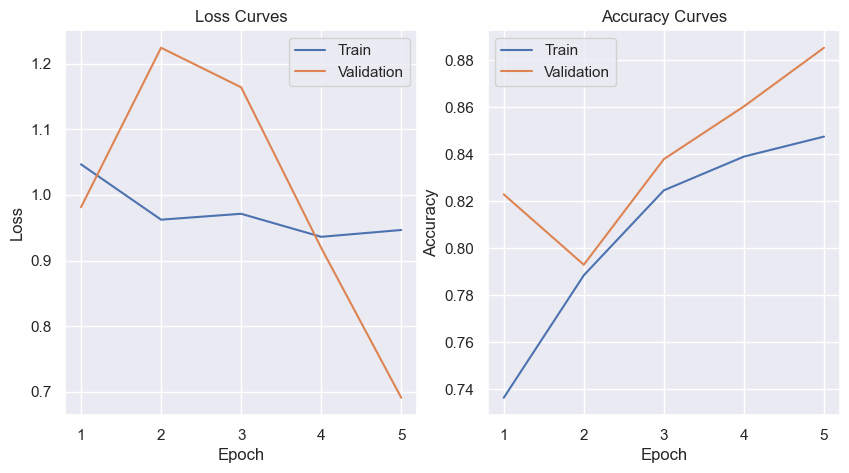

In [16]:
# Train the model
start_time = time.time()
model_ft, training_time = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)
finish_time = start_time + training_time
training_time_minutes = training_time / 60

In [17]:
def test_model(model, dataloader):
    model.eval()

    corrects = 0
    total = 0

    all_preds = []
    all_labels = []
    

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = model(inputs)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    accuracy = corrects/total
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Correct pred: {corrects}")
    print(f"Total pred: {total}")
    print(f"Test Accuracy: {accuracy}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.xlabel("Prediction")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Correct pred: 360
Total pred: 410
Test Accuracy: 0.8780487804878049


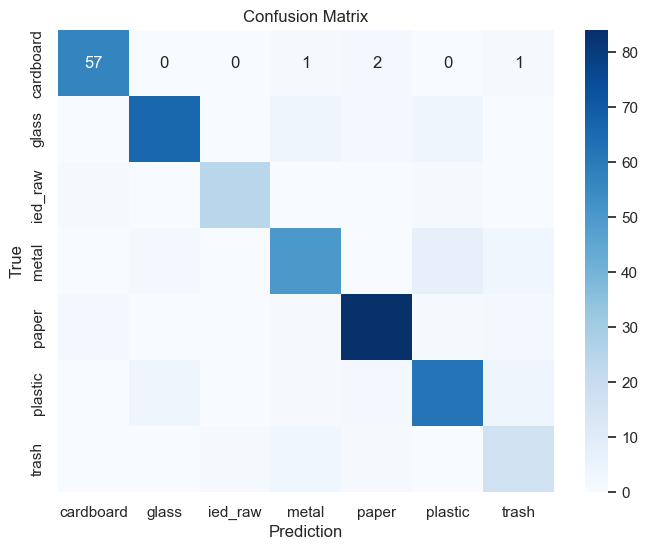

In [18]:
start_time = time.time()
test_model(model_ft, dataloaders["test"])
end_time = time.time()
testing_time = (end_time - start_time) / 60